<a href="https://colab.research.google.com/github/serdarbozoglan/01_Computer_Vision/blob/master/PyTorch08_CIFAR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torch torchvision
!pip install pillow==4.00

In [1]:
import numpy as np
import torch
from torchvision import datasets
import torchvision.transforms as T
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Turn off scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

RANDOM_SEED =4299
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
#tf.random.set_seed(RANDOM_SEED)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [53]:
# First we convert images to Tensors
# Then we normalize the values between [-1, 1]
# first (0.5, 0.5, 0.5) mean of channel, height, width and second ones are std dev for each one 
# Normalize ederken sadece (0.5), (0.5) uygalamaizin nedeni gray scale oldugu icin
# Eger 3 color olsydi (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) uygulayacaktik
# Data Augmentation 
transform_train = T.Compose([T.Resize((32,32)),
                       T.RandomHorizontalFlip(),
                       T.RandomRotation(10),
                       T.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                       T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                       T.ToTensor(),
                       T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                        ])
transform = T.Compose([T.Resize((32,32)),
                       T.ToTensor(),
                       T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                        ])

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# numpy array a cevirecegiz simdi de
# dimension [channels, height, width]
# PLOTLAMAK ICIN [HEIGHT WIDTH CHANNELS] formatinda olmali
# [1, 28, 28] olan format [28, 28, 1] formatinda olmali

def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

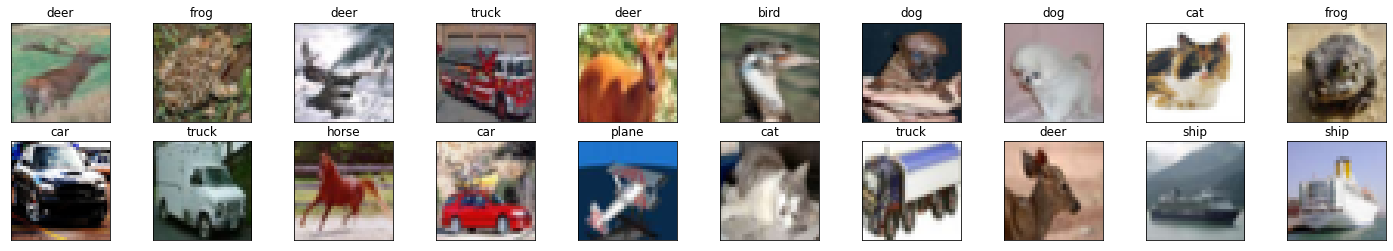

In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])
plt.show();

# TO IMPROVE THE MODEL
- Play araound with learning with such as 0.001
- Deeper Conv Layer (Adding 1-2 more layers)
- Try different kernel size instead of 5, might be 3 etc

In [0]:
### Baseline Model

In [0]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 20, 5, 1) # 3 color channels
      self.conv2 = nn.Conv2d(20, 50, 5, 1)
      self.fc1 = nn.Linear(5*5*50, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 5*5*50)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [8]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [55]:
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    #outputs = model(inputs)
    print(inputs.shape)
    break


torch.Size([100, 3, 32, 32])


In [56]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in tqdm(range(epochs)):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

  7%|▋         | 1/15 [00:40<09:24, 40.29s/it]

epoch : 1
training loss: 1.3090, acc 53.6860 
validation loss: 1.1839, validation acc 57.6700 


 13%|█▎        | 2/15 [01:20<08:42, 40.21s/it]

epoch : 2
training loss: 1.1976, acc 57.6060 
validation loss: 1.0652, validation acc 62.5700 


 20%|██        | 3/15 [02:00<08:00, 40.08s/it]

epoch : 3
training loss: 1.1352, acc 59.7500 
validation loss: 1.0040, validation acc 64.3900 


 27%|██▋       | 4/15 [02:39<07:18, 39.88s/it]

epoch : 4
training loss: 1.0900, acc 61.7420 
validation loss: 0.9722, validation acc 65.6300 


 33%|███▎      | 5/15 [03:18<06:36, 39.69s/it]

epoch : 5
training loss: 1.0421, acc 63.5860 
validation loss: 0.9580, validation acc 66.5600 


 40%|████      | 6/15 [03:58<05:57, 39.72s/it]

epoch : 6
training loss: 1.0067, acc 64.7220 
validation loss: 0.9460, validation acc 67.3300 


 47%|████▋     | 7/15 [04:37<05:15, 39.43s/it]

epoch : 7
training loss: 0.9771, acc 65.8060 
validation loss: 0.9120, validation acc 68.6700 


 53%|█████▎    | 8/15 [05:16<04:35, 39.32s/it]

epoch : 8
training loss: 0.9507, acc 66.7820 
validation loss: 0.9356, validation acc 67.2300 


 60%|██████    | 9/15 [05:55<03:55, 39.23s/it]

epoch : 9
training loss: 0.9304, acc 67.6360 
validation loss: 0.8719, validation acc 69.6300 


 67%|██████▋   | 10/15 [06:34<03:15, 39.05s/it]

epoch : 10
training loss: 0.9160, acc 67.8740 
validation loss: 0.8675, validation acc 70.0600 


 73%|███████▎  | 11/15 [07:12<02:36, 39.01s/it]

epoch : 11
training loss: 0.8957, acc 69.0260 
validation loss: 0.8369, validation acc 71.0000 


 80%|████████  | 12/15 [07:51<01:56, 38.98s/it]

epoch : 12
training loss: 0.8764, acc 69.4820 
validation loss: 0.8425, validation acc 71.4500 


 87%|████████▋ | 13/15 [08:30<01:17, 38.99s/it]

epoch : 13
training loss: 0.8641, acc 69.9740 
validation loss: 0.8325, validation acc 71.8600 


 93%|█████████▎| 14/15 [09:09<00:38, 38.89s/it]

epoch : 14
training loss: 0.8503, acc 70.0960 
validation loss: 0.8230, validation acc 71.9500 


100%|██████████| 15/15 [09:47<00:00, 39.20s/it]

epoch : 15
training loss: 0.8415, acc 70.6900 
validation loss: 0.8492, validation acc 71.3000 


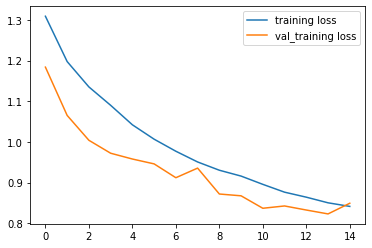

In [57]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='val_training loss')
plt.legend();

In [0]:
def plot_accuracy_and_loss(history, title):

    plt.figure(1, figsize=(15,10))

    # Accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    #plt.plot(history.history['val_categorical_accuracy'])
    plt.title(title+' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='best')

    # Loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
   # plt.plot(history.history['val_loss'])
    plt.title(title+' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='best')

### Testing The Model

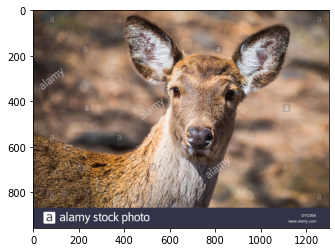

In [59]:
from PIL import Image
import PIL.ImageOps
import requests

url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

In [60]:
print(img.format)
print(img.size)
print(img.mode)

JPEG
(1300, 956)
RGB


### Image i Data'ya cevirmek icin

In [0]:
img = np.asarray(img)

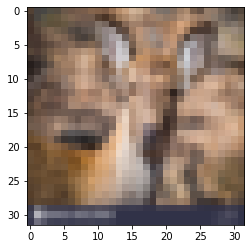

In [62]:
# from PIL import ToPILImage
img = T.ToPILImage()(img)

# Preprocssing
img = transform(img) 
plt.imshow(im_convert(img))

In [63]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, dim=1)
print(classes[pred.item()])

deer


### Batch Prediction From Validation Set

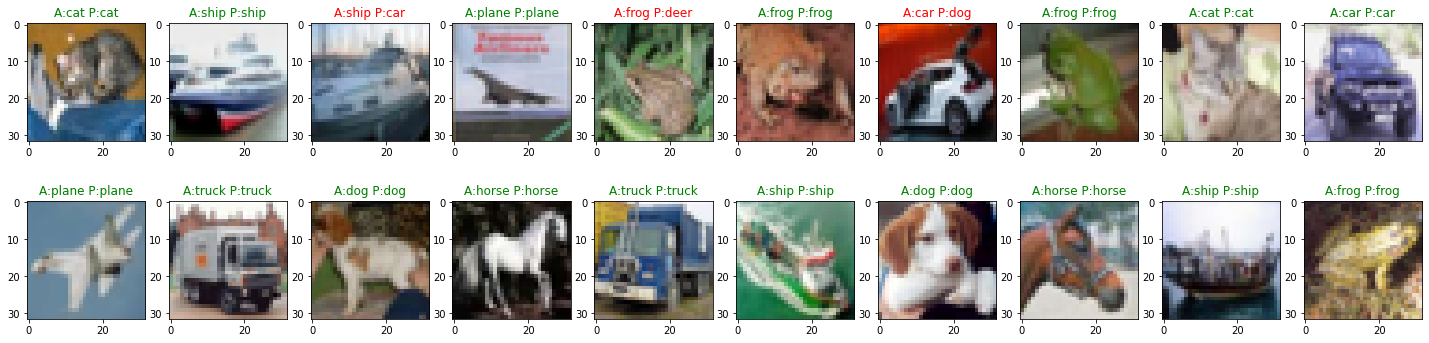

In [64]:
data_iter = iter(validation_loader);

# data_iter.next() --> bring us a BATCH of data each time
images, labels = data_iter.next();
images = images.to(device)
labels = labels.to(device) 
outputs = model(images)
_, preds = torch.max(outputs, dim=1) 

fig = plt.figure(figsize=(25, 6));

# We ll check 20 images from training set
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1);
    plt.imshow(im_convert(images[idx]));
    # A: Actula P:Predicted
    ax.set_title("A:{} P:{}".format(str(classes[labels[idx].item()]), str(classes[preds[idx].item()])), color=('green' if preds[idx]==labels[idx] else 'red'));
plt.show();

### Below Not Related to This Notebook Preprocessing

In [0]:
# We need to convert into gray scale
# Bunun icin tekrar okumamiz lazim cunku RGB'edn Gray e donusturemiyoruz but BGR to Gray available
from google.colab.patches import cv2_imshow
%matplotlib inline
img = cv2.imread('number2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Original image
cv2_imshow(gray)
# showing smaller
plt.imshow(gray, cmap='gray');

In [0]:
gray.shape

In [0]:
### Hala istedigimiz gibi degil, Threshold kullanarak belli bir degerin altini blak sonra white yapacahiz

(thresh, blackAndWhiteImage) = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY_INV)
plt.imshow(blackAndWhiteImage, cmap='gray');
print ('New Shape is:', blackAndWhiteImage.shape);
# Evet bu istedigimiz format

In [0]:
# Saving image
cv2.imwrite('black2.jpg', blackAndWhiteImage)

In [0]:
!pip install pillow==4.1.1
!pip install --user opencv-contrib-python
%reload_ext autoreload
%autoreload

# COK ONEMLI: 
cv2.imread otomatik olarak 3 color channel olarak okur, gray scale olsa bile, flag'e dikkat et gray scale okurken

In [0]:
from PIL import Image
img = cv2.imread('black2.jpg', cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)
#plt.imshow(img);
print('image shape', img.shape);

In [0]:
# We need to tranform image what we appiled above, resizing etc
from PIL import Image
PIL_image = Image.fromarray(img)
img = transform(PIL_image)
plt.imshow(image_convert(img));

In [0]:
img.shape

In [0]:
img =img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, dim=1)
print(pred.item())
# 3 olarak predict etti HATA

In [0]:
img = cv2.imread('number5.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [0]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
print('shape:', gray.shape);

In [0]:
(thresh, blackAndWhiteImage) = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY)
plt.imshow(blackAndWhiteImage, cmap='gray');
# This is what we want

In [0]:
PIL_image = Image.fromarray(blackAndWhiteImage)
img = transform(PIL_image)
plt.imshow(image_convert(img));

In [0]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, dim=1)
print(pred.item())
# This time correct

In [48]:
print('Bismillahirrahmanirrahim')

Bismillahirrahmanirrahim
